## Resumo aula 7 de Machine Learning 2 ##

## 1. DBSCAN

O DBSCAN é um algoritmo de clusterização baseado no conceito de **densidade**.

O nome do algoritmo é uma sigla, que explica bem seu funcionamento: **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise.

O algoritmo foi proposto com o objetivo de proporcionar uma técnica de clusterização que possa funcionar **mesmo quando os clusters a serem criados não forem uniformes**, tendo **tamanho, forma e densidade variáveis**. 

Além disso, por construção o método funciona bem em contextos em que há **ruídos/outliers**, sendo capaz de detectá-los sem influenciar a criação dos clusters. 

Por fim, uma vantagem enorme é o fato do algoritmo **não demandar a determinação prévia da quantidade de clusters**, o que é uma vantagem interessante se não houver indicações do problema de negócio para esta determinação (embora, como veremos, ainda há hiperparâmetros importantes a serem determinados).

<img src=https://www.researchgate.net/publication/315326812/figure/fig2/AS:473095908663297@1489806262333/A-cluster-consists-of-core-points-red-and-border-points-green-Core-points-have-at.png width=500>

<img src=https://www.researchgate.net/publication/335485895/figure/fig2/AS:797412515909651@1567129367940/A-single-DBSCAN-cluster-with-Core-Border-and-Noise-Points.ppm width=500>

Dada a definição acima, podemos classificar pontos dentro de um cluster como:

> **Core points (pontos centrais)**: são pontos que estão no interior dos clusters (regiões densas). Matematicamente, um ponto é considerado core **se sua densidade é de pelo menos $\text{minPts}$**, ou seja, se **há pelo menos $\text{minPts}$ pontos dentro do círculo de raio $\epsilon$ centrado no ponto**.

> **Border points (pontos de fronteira)**: são pontos que estão na fronteira de um cluster. Matematicamente, estes pontos **têm densidade menor que $\text{minPts}$**, mas que **fazem parte da vizinhança-$\epsilon$ de um ponto central**.

> **Noisy points (pontos de ruído/outliers)**: são pontos que não são centrais nem de fronteira. Estes pontos não fazem parte do cluster, e são considerados outliers.


Olhando para as definições acima, e pras figuras, fica claro que $\epsilon$ e $\text{minPts}$ são os hiperparâmetros do modelo -- e que os clusters gerados são fortemente dependentes destes hiperparâmetros!


> - $\epsilon$ (`eps` no sklearn): determina o quão próximos (relativo a uma dada **métrica de distância**) os pontos devem estar próximos entre si para serem considerados vizinhos, e, eventualmente, parte de um cluster. Na prática, **se a distância entre dois pontos for menor ou igual a $\epsilon$, os pontos serão considerados vizinhos**;
<br><br>
>Se o valor de `eps` for muito pequeno, grande parte dos dados não serão clusterizados - muitos pontos serão considerados outliers, pois não haverá vizinhos suficientes para gerar uma região densa;<br><br>
>Por outro lado, se o valor de `eps` for muito grande, os clusters se fundirão, e a maioria dos pontos estarão em um único, grande cluster.<br><br>
>Portanto, a escolha de `eps` está muito relacionada com **a escala** das features, o que demanda cuidadosa análise exploratória.<br><br>
>Além disso, note que o  `eps` depende também fortemente da **métrica de distância** (`metric` no sklearn) a ser utilizada.


> - $\text{minPts}$ (`min_samples` no sklearn): o número mínimo de pontos que devem ser vizinhos para formar uma região densa, que será um cluster.
<br><br>
Valores maiores de `min_samples` são preferíveis para datasets com outliers, formando clusters mais significativos (isto é, um cluster só será formado se realmente tiver uma alta densidade).

Para algumas dicas práticas de como estimar bons valores para os hiper-parâmetros, [clique aqui](https://en.wikipedia.org/wiki/DBSCAN#Parameter_estimation).

Podemos visualizar a seguir o DBSCAN em funcionamento:


<img src="http://data-analysis-stats.jp/wp-content/uploads/2019/09/DBSCAN_01.gif" width=400>


<img src=https://i.pinimg.com/originals/bb/3d/5e/bb3d5e522cbcb2dd07a81f8118de2041.gif width=500>


**Exercício 1**

Aplique a clusterização DBSCAN no conjunto de dados `german-credit-data.csv`, segundo as instruções:

- não precisa separar conjunto de treino e teste
- construa um objeto processador para resolver problemas de dados faltantes e tratar variáveis categóricas.
- utilize a mesma metodologia apresentada para selecionar os hiperparâmetros do DBSCAN
- analise as estatísticas descritivas de cada cluster com o método `groupby`
- se houver, analise os *outliers*

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, completeness_score
from sklearn.cluster import DBSCAN
from sklearn.model_selection import RandomizedSearchCV


In [24]:
credit_data = pd.read_csv('german_credit_data.csv')
credit_data.info()
credit_data.drop(['Unnamed: 0','Risk'], axis=1, inplace=True)

cat_columns = credit_data.select_dtypes(exclude=np.number).columns.tolist()
cat_impute = Pipeline([('cat_impute', SimpleImputer(strategy='constant', fill_value='None')),
                        ('ohe',OrdinalEncoder())])

preprocessing = ColumnTransformer([('cat_transform', cat_impute, cat_columns)],remainder='passthrough')


def dbscan_plot(data,eps,min_samples):
    data_copy = data.copy()

    pipe_final = Pipeline([('preprocessing',preprocessing),
                           ('std_scaler', StandardScaler()),
                           ('dbscan', DBSCAN(eps=eps, min_samples=min_samples))])
    
    data_cluster = data_copy.copy()

    pipe_final.fit(data_copy)

    data_cluster['cluster'] = pipe_final['dbscan'].labels_

    print(f'Gráficos com eps = {eps}, e min_samples = {min_samples}')

    sns.pairplot(data_cluster, hue='cluster', palette='coolwarm')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [25]:
def dbscan_evaluate(data,eps,min_samples):
    data_copy = data.copy()
    transf_pipe = Pipeline([
        ('preprocess', preprocessing),
        ('scaler', StandardScaler())
    ])

    # aplicando a transformação nos dados (apenas para calcular o score de silhueta)
    x2 = transf_pipe.fit_transform(data_copy)

    pipe_final = Pipeline([('preprocessing',preprocessing),
                           ('std_scaler', StandardScaler()),
                           ('dbscan', DBSCAN(eps=eps, min_samples=min_samples))])
    
    data_cluster = data_copy.copy()

    pipe_final.fit(data_copy)

    return silhouette_score(x2, pipe_final['dbscan'].labels_)

In [26]:
# criando ranges de busca
eps_list = np.arange(0.5, 3.9, 0.1)
min_pt_list = np.arange(1, 6, 1)
results = pd.DataFrame(columns=['eps', 'min_pts', 's_score'])

# iterar pelos ranges de busca
i = 0
for eps in eps_list:
    for min_pt in min_pt_list:

        # calculando o score
        s_score = dbscan_evaluate(credit_data, eps, min_pt)

        # alocando resultados
        results.loc[i, ['eps', 'min_pts', 's_score']] = eps, min_pt, s_score

        i += 1

# ordenar pelo maior s_score
results.sort_values(by=['s_score'], ascending=False)

,eps,min_pts,s_score
157,3.6,3,0.400031
143,3.3,4,0.400031
142,3.3,3,0.400031
146,3.4,2,0.400031
147,3.4,3,0.400031
...,...,...,...
7,0.6,3,-0.316798
1,0.5,2,-0.317663
8,0.6,4,-0.324661
3,0.5,4,-0.348993


Gráficos com eps = 3.6, e min_samples = 3


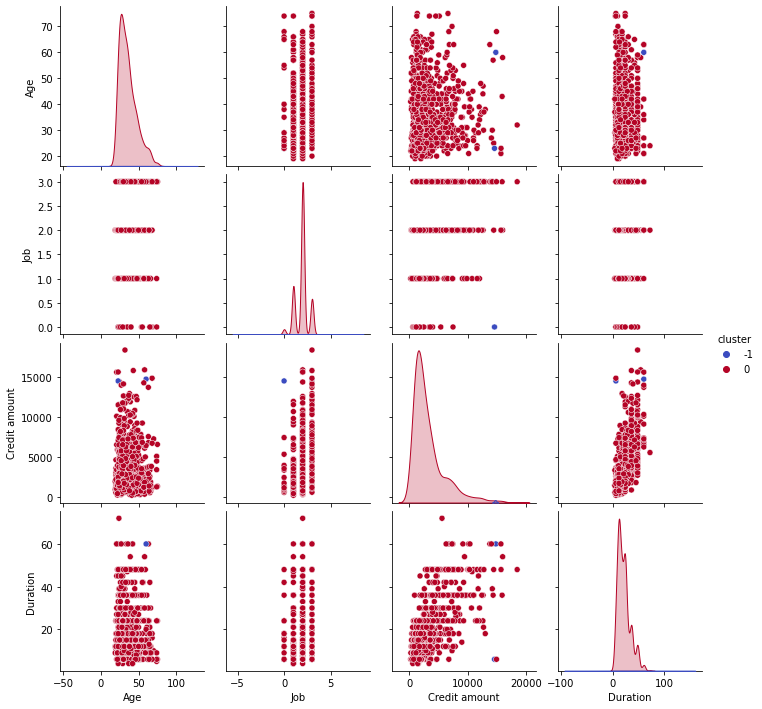

In [28]:
dbscan_plot(credit_data,3.6,3)

In [27]:
# função para avaliar a influência dos hiperparâmetros
def eval_dbscan(x, eps, min_pts):

    # cópia de x
    x1 = x.copy()

    # pipeline de transformação
    transf_pipe = Pipeline([
        ('preprocess', pre_processador),
        ('scaler', StandardScaler())
    ])

    # aplicando a transformação nos dados (apenas para calcular o score de silhueta)
    x2 = transf_pipe.fit_transform(x1)

    # criar o pipeline final de modelagem
    dbscan_pipe = Pipeline([
        ('preprocess', pre_processador),
        ('scaler', StandardScaler()),
        ('dbscan', DBSCAN(eps=eps,min_samples=min_pts))
    ])

    # ajuste do modelo aos dados
    dbscan_pipe.fit(x1)

    # retornar o score de silhueta médio
    return silhouette_score(x2, labels=dbscan_pipe['dbscan'].labels_)